##### Copyright 2019 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Approximate inference for STS models with non-Gaussian observations


This notebook demonstrates the use of TFP approximate inference tools to incorporate a (non-Gaussian) observation model when fitting and forecasting with structural time series (STS) models. In this example, we'll use a Poisson observation model to work with discrete count data.

In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

tf.enable_v2_behavior()

2023-08-13 10:49:36.624370: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Synthetic Data

First we'll generate some synthetic count data:

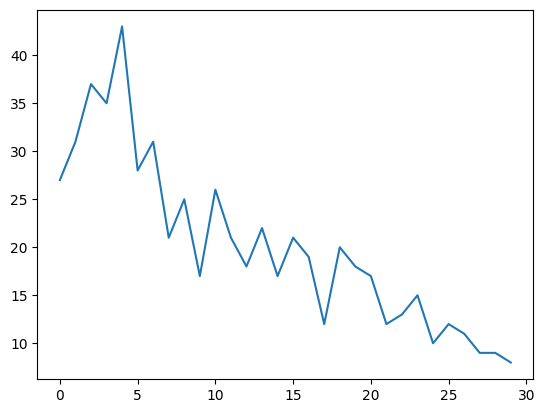

In [3]:
num_timesteps = 30
observed_counts = np.round(3 + np.random.lognormal(np.log(np.linspace(
    num_timesteps, 5, num=num_timesteps)), 0.20, size=num_timesteps)) 
observed_counts = observed_counts.astype(np.float32)
plt.plot(observed_counts)

## Model

We'll specify a simple model with a randomly walking linear trend:

In [4]:
def build_model(approximate_unconstrained_rates):
  trend = tfp.sts.LocalLinearTrend(
      observed_time_series=approximate_unconstrained_rates)
  return tfp.sts.Sum([trend],
                     observed_time_series=approximate_unconstrained_rates)

Instead of operating on the observed time series, this model will operate on the series of Poisson rate parameters that govern the observations.

Since Poisson rates must be positive, we'll use a bijector to transform the
real-valued STS model into a distribution over positive values. The `Softplus`
transformation $y = \log(1 + \exp(x))$ is a natural choice, since it is nearly linear for positive values, but other choices such as `Exp` (which transforms the normal random walk into a lognormal random walk) are also possible.

In [5]:
positive_bijector = tfb.Softplus()  # Or tfb.Exp()

# Approximate the unconstrained Poisson rate just to set heuristic priors.
# We could avoid this by passing explicit priors on all model params.
approximate_unconstrained_rates = positive_bijector.inverse(
    tf.convert_to_tensor(observed_counts) + 0.01)
sts_model = build_model(approximate_unconstrained_rates)

2023-08-13 10:49:41.573981: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-13 10:49:41.615574: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-13 10:49:41.615964: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-13 10:49:41.621282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-13 10:49:41.621684: I tensorflow/compile

To use approximate inference for a non-Gaussian observation model,
we'll encode the STS model as a TFP JointDistribution. The random variables in this joint distribution are the parameters of the STS model, the time series of latent Poisson rates, and the observed counts.


In [6]:
def sts_with_poisson_likelihood_model():
  # Encode the parameters of the STS model as random variables.
  param_vals = []
  for param in sts_model.parameters:
    param_val = yield param.prior
    param_vals.append(param_val)

  # Use the STS model to encode the log- (or inverse-softplus)
  # rate of a Poisson.
  unconstrained_rate = yield sts_model.make_state_space_model(
      num_timesteps, param_vals)
  rate = positive_bijector.forward(unconstrained_rate[..., 0])
  observed_counts = yield tfd.Poisson(rate, name='observed_counts')

model = tfd.JointDistributionCoroutineAutoBatched(sts_with_poisson_likelihood_model)

### Preparation for inference

We want to infer the unobserved quantities in the model, given the observed counts. First, we condition the joint log density on the observed counts.

In [7]:
pinned_model = model.experimental_pin(observed_counts=observed_counts)


We'll also need a constraining bijector to ensure that inference respects the constraints on the STS model's parameters (for example, scales must be positive).

In [8]:
constraining_bijector = pinned_model.experimental_default_event_space_bijector()

## Inference with HMC

We'll use HMC (specifically, NUTS) to sample from the joint posterior over model parameters and latent rates.

This will be significantly slower than fitting a standard STS model with HMC, since in addition to the model's (relatively small number of) parameters we also have to infer the entire series of Poisson rates. So we'll run for a relatively small number of steps; for applications where inference quality is critical it might make sense to increase these values or to run multiple chains.

In [9]:
#@title Sampler configuration

# Allow external control of sampling to reduce test runtimes.
num_results = 500 # @param { isTemplate: true}
num_results = int(num_results)

num_burnin_steps = 100 # @param { isTemplate: true}
num_burnin_steps = int(num_burnin_steps)

First we specify a sampler, and then use `sample_chain` to run that sampling
kernel to produce samples.

In [11]:
sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=pinned_model.unnormalized_log_prob,
        step_size=0.1),
    bijector=constraining_bijector)

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=0.75)

##tf.random.normal doesn't work and bricks the tensorflow container
initial_state = constraining_bijector.forward(
    type(pinned_model.event_shape)(
        *(tf.random.Generator(part_shape)
          for part_shape in constraining_bijector.inverse_event_shape(
              pinned_model.event_shape))))

AttributeError: 'TensorShape' object has no attribute 'state'

In [ ]:
# Speed up sampling by tracing with `tf.function`.
@tf.function(autograph=False, jit_compile=True)
def do_sampling():
  return tfp.mcmc.sample_chain(
      kernel=adaptive_sampler,
      current_state=initial_state,
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      trace_fn=None)

t0 = time.time()
samples = do_sampling()
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))

We can sanity-check the inference by examining the parameter traces. In this case they appear to have explored multiple explanations for the data, which is good, although more samples would be helpful to judge how well the chain is mixing.

In [ ]:
f = plt.figure(figsize=(12, 4))
for i, param in enumerate(sts_model.parameters):
  ax = f.add_subplot(1, len(sts_model.parameters), i + 1)
  ax.plot(samples[i])
  ax.set_title("{} samples".format(param.name))

Now for the payoff: let's see the posterior over Poisson rates! We'll also plot the 80% predictive interval over observed counts, and can check that this interval appears to contain about 80% of the counts we actually observed.

In [ ]:
param_samples = samples[:-1]
unconstrained_rate_samples = samples[-1][..., 0]
rate_samples = positive_bijector.forward(unconstrained_rate_samples)

plt.figure(figsize=(10, 4))
mean_lower, mean_upper = np.percentile(rate_samples, [10, 90], axis=0)
pred_lower, pred_upper = np.percentile(np.random.poisson(rate_samples), 
                                       [10, 90], axis=0)

_ = plt.plot(observed_counts, color="blue", ls='--', marker='o', label='observed', alpha=0.7)
_ = plt.plot(np.mean(rate_samples, axis=0), label='rate', color="green", ls='dashed', lw=2, alpha=0.7)
_ = plt.fill_between(np.arange(0, 30), mean_lower, mean_upper, color='green', alpha=0.2)
_ = plt.fill_between(np.arange(0, 30), pred_lower, pred_upper, color='grey', label='counts', alpha=0.2)
plt.xlabel("Day")
plt.ylabel("Daily Sample Size")
plt.title("Posterior Mean")
plt.legend()

## Forecasting

To forecast the observed counts, we'll use the standard STS tools to build a forecast distribution over the latent rates (in unconstrained space, again since STS is designed to model real-valued data), then pass the sampled forecasts through a Poisson observation model:

In [ ]:
def sample_forecasted_counts(sts_model, posterior_latent_rates,
                             posterior_params, num_steps_forecast,
                             num_sampled_forecasts):

  # Forecast the future latent unconstrained rates, given the inferred latent
  # unconstrained rates and parameters.
  unconstrained_rates_forecast_dist = tfp.sts.forecast(sts_model,
    observed_time_series=unconstrained_rate_samples,
    parameter_samples=posterior_params,
    num_steps_forecast=num_steps_forecast)

  # Transform the forecast to positive-valued Poisson rates.
  rates_forecast_dist = tfd.TransformedDistribution(
      unconstrained_rates_forecast_dist,
      positive_bijector)

  # Sample from the forecast model following the chain rule:
  # P(counts) = P(counts | latent_rates)P(latent_rates)
  sampled_latent_rates = rates_forecast_dist.sample(num_sampled_forecasts)
  sampled_forecast_counts = tfd.Poisson(rate=sampled_latent_rates).sample()

  return sampled_forecast_counts, sampled_latent_rates

forecast_samples, rate_samples = sample_forecasted_counts(
   sts_model,
   posterior_latent_rates=unconstrained_rate_samples,
   posterior_params=param_samples,
   # Days to forecast:
   num_steps_forecast=30,
   num_sampled_forecasts=100)

In [ ]:
forecast_samples = np.squeeze(forecast_samples)

In [ ]:
def plot_forecast_helper(data, forecast_samples, CI=90):
  """Plot the observed time series alongside the forecast."""
  plt.figure(figsize=(10, 4))
  forecast_median = np.median(forecast_samples, axis=0)

  num_steps = len(data)
  num_steps_forecast = forecast_median.shape[-1]

  plt.plot(np.arange(num_steps), data, lw=2, color='blue', linestyle='--', marker='o',
           label='Observed Data', alpha=0.7)

  forecast_steps = np.arange(num_steps, num_steps+num_steps_forecast)

  CI_interval = [(100 - CI)/2, 100 - (100 - CI)/2]
  lower, upper = np.percentile(forecast_samples, CI_interval, axis=0)

  plt.plot(forecast_steps, forecast_median, lw=2, ls='--', marker='o', color='orange',
           label=str(CI) + '% Forecast Interval', alpha=0.7)
  plt.fill_between(forecast_steps,
                   lower,
                   upper, color='orange', alpha=0.2)

  plt.xlim([0, num_steps+num_steps_forecast])
  ymin, ymax = min(np.min(forecast_samples), np.min(data)), max(np.max(forecast_samples), np.max(data))
  yrange = ymax-ymin
  plt.title("{}".format('Observed time series with ' + str(num_steps_forecast) + ' Day Forecast'))
  plt.xlabel('Day')
  plt.ylabel('Daily Sample Size')
  plt.legend()

In [ ]:
plot_forecast_helper(observed_counts, forecast_samples, CI=80)

## VI inference

Variational inference can be problematic when inferring a full time series, like our approximate counts (as opposed to just
the *parameters* of a time series, as in standard STS models). The standard assumption that variables have independent posteriors is quite wrong, since each timestep is correlated with its neighbors, which can lead to underestimating uncertainty. For this reason, HMC may be a better choice for approximate inference over full time series. However, VI can be quite a bit faster, and may be useful for model prototyping or in cases where its performance can be empirically shown to be 'good enough'.

To fit our model with VI, we simply build and optimize a surrogate posterior:

In [ ]:
surrogate_posterior = tfp.experimental.vi.build_factored_surrogate_posterior(
    event_shape=pinned_model.event_shape,
    bijector=constraining_bijector)

In [ ]:
# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 1000 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

t0 = time.time()
losses = tfp.vi.fit_surrogate_posterior(pinned_model.unnormalized_log_prob,
                                        surrogate_posterior,
                                        optimizer=tf.optimizers.Adam(0.1),
                                        num_steps=num_variational_steps)
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))

In [ ]:
plt.plot(losses)
plt.title("Variational loss")
_ = plt.xlabel("Steps")

In [ ]:
posterior_samples = surrogate_posterior.sample(50)
param_samples = posterior_samples[:-1]
unconstrained_rate_samples = posterior_samples[-1][..., 0]
rate_samples = positive_bijector.forward(unconstrained_rate_samples)

plt.figure(figsize=(10, 4))
mean_lower, mean_upper = np.percentile(rate_samples, [10, 90], axis=0)
pred_lower, pred_upper = np.percentile(
    np.random.poisson(rate_samples), [10, 90], axis=0)

_ = plt.plot(observed_counts, color='blue', ls='--', marker='o',
             label='observed', alpha=0.7)
_ = plt.plot(np.mean(rate_samples, axis=0), label='rate', color='green',
             ls='dashed', lw=2, alpha=0.7)
_ = plt.fill_between(
    np.arange(0, 30), mean_lower, mean_upper, color='green', alpha=0.2)
_ = plt.fill_between(np.arange(0, 30), pred_lower, pred_upper, color='grey',
    label='counts', alpha=0.2)
plt.xlabel('Day')
plt.ylabel('Daily Sample Size')
plt.title('Posterior Mean')
plt.legend()

In [ ]:
forecast_samples, rate_samples = sample_forecasted_counts(
   sts_model,
   posterior_latent_rates=unconstrained_rate_samples,
   posterior_params=param_samples,
   # Days to forecast:
   num_steps_forecast=30,
   num_sampled_forecasts=100)

In [ ]:
forecast_samples = np.squeeze(forecast_samples)

In [ ]:
plot_forecast_helper(observed_counts, forecast_samples, CI=80)